# Slab model

The purpose of `dustpylib.radtrans.slab` is to implement a simple, plane-parallel slab solution for protoplanetary disks and to compute those based on files from `DustPy` simulations.  

In this notebook we are going to produce a radio images from the [planetary gaps example](https://stammler.github.io/dustpy/example_planetary_gaps.html) in the `DustPy` documentation. This repository contains a reduced `DustPy` output file of the final snapshot of the example model only containing the fields that are required to produce the `RADMC-3D` model. We will use the same to compute such an image with the slab model for comparison.

All quantities are in CGS units.

In the first step we need to load the `DustPy` data file using the `hdf5writer` for this.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from dustpy import hdf5writer
import dustpy.constants as c
from dustpylib.radtrans import radmc3d

In [2]:

writer = hdf5writer()
writer.datadir = "example_planetary_gaps"
data = writer.read.output(21)

## Creating the `RADMC-3D` model for comparison

To compare the results of the slab model with a "ground truth" result use `RADMC-3D`. The following cell is taken from the `radmc3d.ipynb` notebook but only creates the continuum image.

In [3]:
plt.rcParams["figure.dpi"] = 150.
rt = radmc3d.Model(data)

rt.phii_grid = np.array([0., 2.*np.pi])
rt.ai_grid = np.geomspace(rt.a_dust_.min(), 1., 17)
rt.radmc3d_options["nphot"] = 500_000
rt.radmc3d_options["nphot_scat"] = 500_000
rt.radmc3d_options["nphot_spec"] = 10_000
rt.radmc3d_options["mc_scat_maxtauabs"] = 5.
rt.radmc3d_options["dust_2daniso_nphi"] = 60
rt.datadir = "radmc3d"
rt.write_files()
img_name = Path(rt.datadir) / 'image_radio.out'
!cd {rt.datadir} && radmc3d image lambda 1300 sizeau 100 npixx 512 npixy 512 setthreads 8
!mv  {Path(rt.datadir) / 'image.out'} {img_name}
image_radio = radmc3d.read_image(img_name)

Writing radmc3d/radmc3d.inp.....done.
Writing radmc3d/stars.inp.....done.
Writing radmc3d/wavelength_micron.inp.....done.
Writing radmc3d/amr_grid.inp.....done.
Writing radmc3d/dust_density.inp.....done.
Writing radmc3d/dust_temperature.dat.....done.
Writing radmc3d/dustopac.inp.....done.

Computing opacities...
Using dsharp_opac. Please cite Birnstiel et al. (2018).
Using DSHARP mix. Please cite Birnstiel et al. (2018).
Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| 

/Users/birnstiel/miniforge3/lib/python3.10/site-packages/dsharp_opac/dsharp_opac.py:2861: RuntimeWarning: invalid value encountered in scalar divide
  g[grain, i] = -2 * np.pi * \


done.
Writing radmc3d/dustkapscatmat_02.inp.....done.
Writing radmc3d/dustkapscatmat_03.inp.....done.
Writing radmc3d/dustkapscatmat_04.inp.....done.
Writing radmc3d/dustkapscatmat_05.inp.....done.
Writing radmc3d/dustkapscatmat_06.inp.....done.
Writing radmc3d/dustkapscatmat_07.inp.....done.
Writing radmc3d/dustkapscatmat_08.inp.....done.
Writing radmc3d/dustkapscatmat_09.inp.....done.
Writing radmc3d/dustkapscatmat_10.inp.....done.
Writing radmc3d/dustkapscatmat_11.inp.....done.
Writing radmc3d/dustkapscatmat_12.inp.....done.
Writing radmc3d/dustkapscatmat_13.inp.....done.
Writing radmc3d/dustkapscatmat_14.inp.....done.
Writing radmc3d/dustkapscatmat_15.inp.....done.

Writing radmc3d/metadata.npz.....done.
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
               

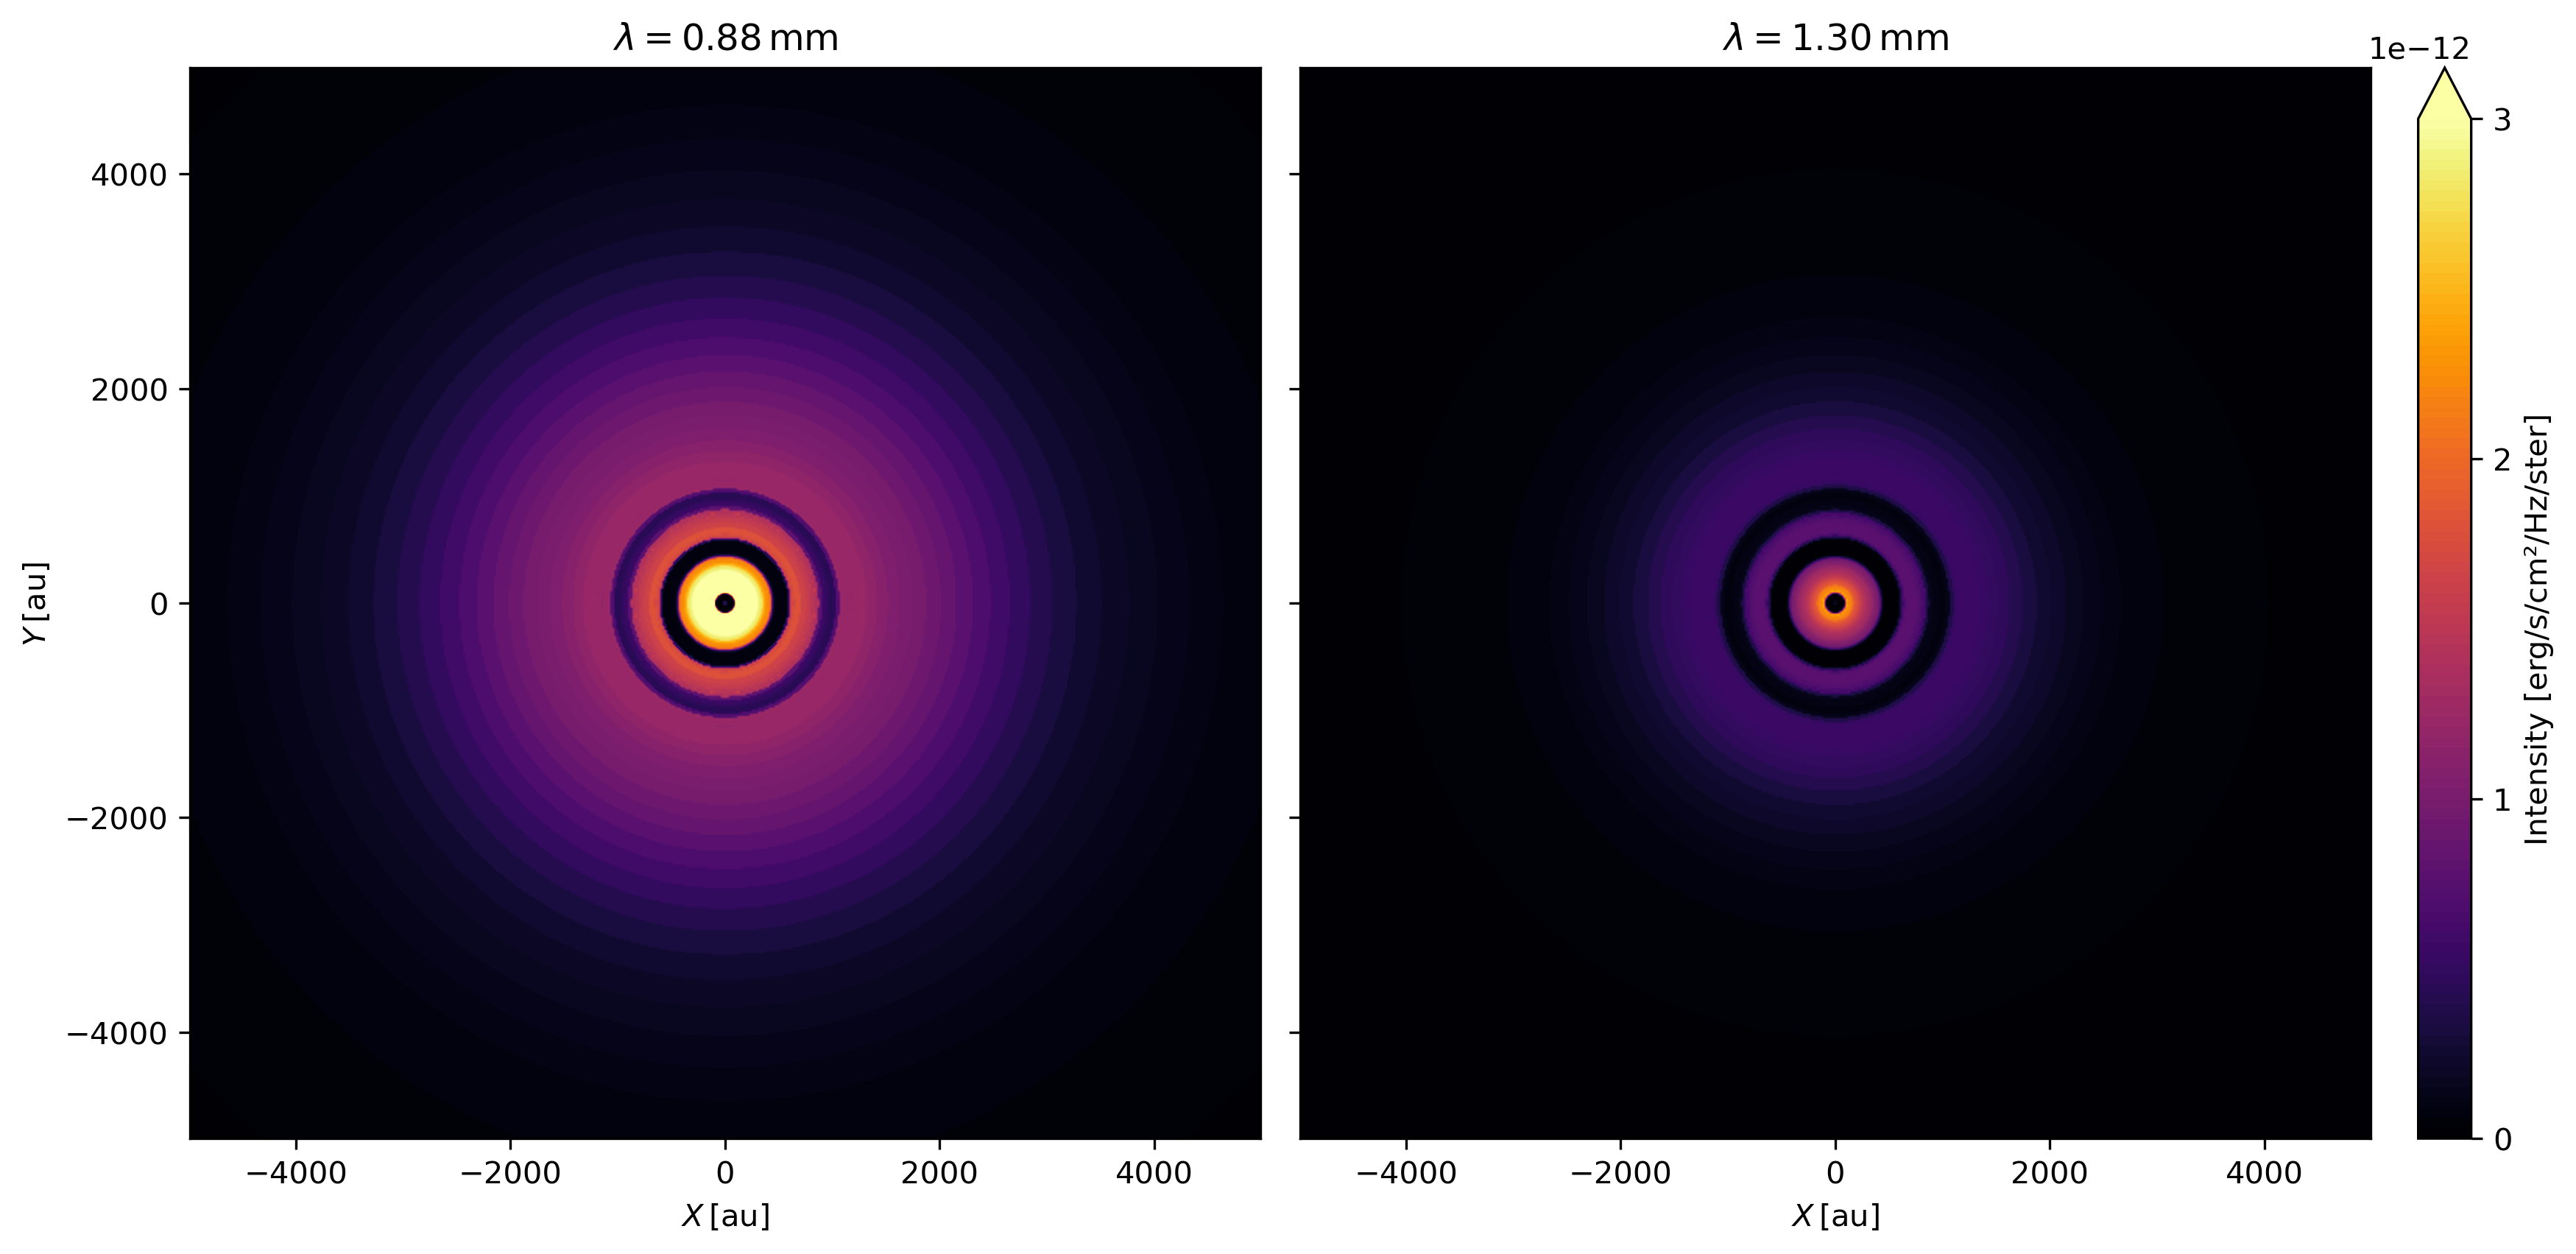

In [21]:
width = 6.
height = width
x, y = image_radio["x"] / c.au, image_radio["y"] / c.au
Imax = 0.5*image_radio["I"].max()
mag = np.floor(np.log10(Imax))
logmax = np.ceil(Imax * 10**(-mag))
levels = np.linspace(0., logmax, 100) * 10**mag
ticks = np.arange(int(logmax)+1) * 10**mag
fig, ax = plt.subplots(ncols=2, figsize=(2*width, height), sharey=True)
ax[0].set_aspect(1)
ax[0].contourf(x, y, image_radio["I"][..., 0].T, cmap="inferno", levels=levels, extend="max")
ax[0].set_title("$\lambda = {:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][0]*10.))
ax[0].set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
ax[0].set_ylabel(r"$Y\,\left[\mathrm{au}\right]$")
ax[1].set_aspect(1)
p = ax[1].contourf(x, y, image_radio["I"][..., 1].T, cmap="inferno", levels=levels, extend="max")
ax[1].set_title("$\lambda = {:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][1]*10.))
ax[1].set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
fig.tight_layout()
fig.subplots_adjust(right=0.9)
pos01 = ax[1].get_position()
cb_ax = fig.add_axes([1.02*pos01.x1, pos01.y0, 0.02, pos01.y1-pos01.y0])
cbar = fig.colorbar(p, cax=cb_ax)
cbar.set_ticks(ticks)
cbar.set_label(r"Intensity [erg/s/cm²/Hz/ster]")

In [48]:
from dustpylib.radtrans import slab

In [49]:
if rt.opacity == 'birnstiel2018':
    opacity_file = 'default_opacities_smooth.npz'
else:
    opacity_file = None

In [56]:
opac = slab.Opacity(opacity_file)
lam = image_radio['lambda']

In [98]:
from importlib import reload
from dustpylib.radtrans.slab import slab
reload(slab)

<module 'dustpylib.radtrans.slab.slab' from '/Users/birnstiel/CODES/dustpylib/dustpylib/radtrans/slab/slab.py'>

In [99]:
obs = slab.get_all_observables(data, opac, lam)

In [150]:
from scipy.stats import binned_statistic
X, Y = np.meshgrid(image_radio['x'], image_radio['y'], indexing='ij')
R = np.sqrt(X**2 + Y**2)
# define the bins
ri_bins = np.geomspace(np.abs(R).min(), R.max(), 100)
r_bins = 0.5 * (ri_bins[1:] + ri_bins[:-1])
# get the averaged intensity profile
profile = binned_statistic(R.ravel(), image_radio['I'][...,0].ravel(), bins=ri_bins).statistic

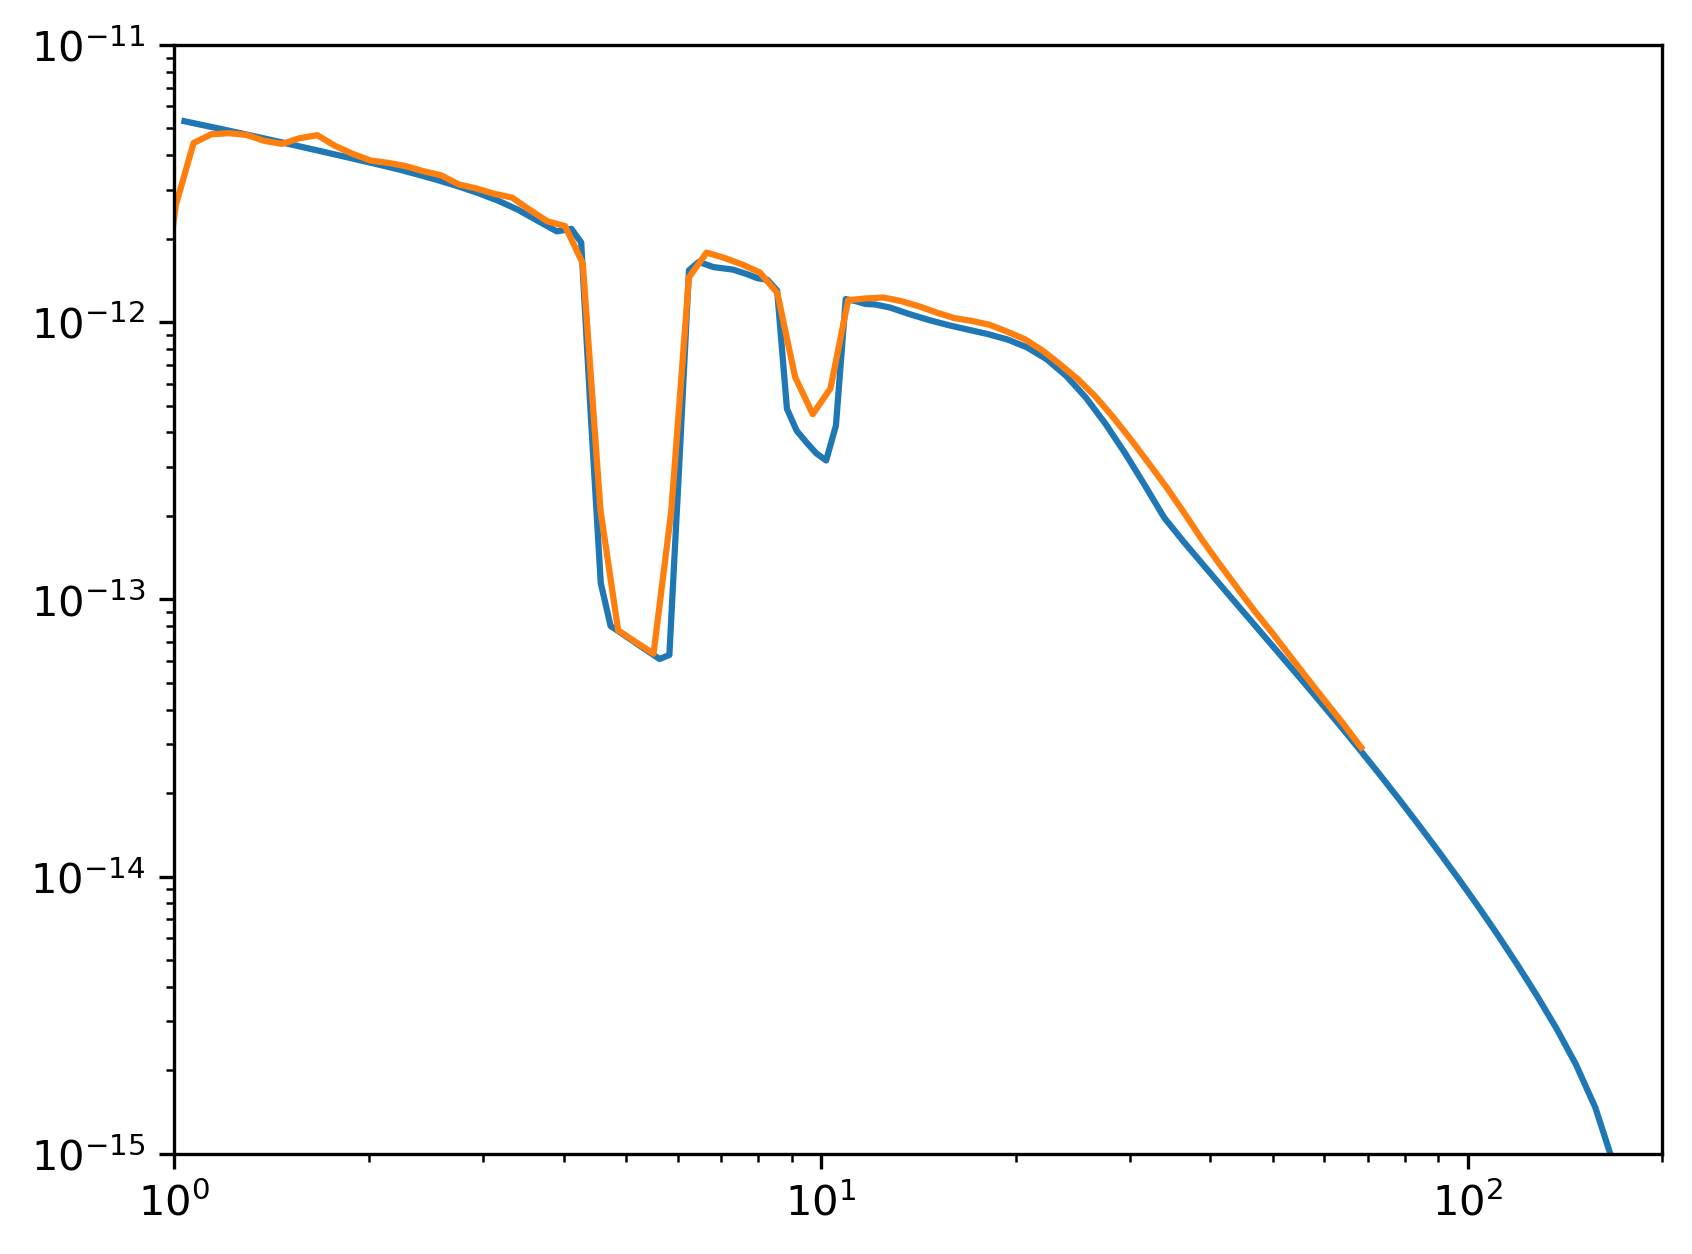

In [152]:
f, ax = plt.subplots()
ax.loglog(data.grid.r / c.au, obs.I_nu[0, 0, :] * slab.jy_sas)
ax.loglog(r_bins / c.au, profile)
ax.set(ylim=[1e-15, 1e-11], xlim=[1, 200]);